In [1]:
# DEFINING REQUIRED PACKAGES ---------------------------------------
import matplotlib.pyplot as plt #import matplotlib to create plots
import scipy.optimize as opt; #allows for curve fitting
from scipy.odr import *
import pandas as pd #importing pandas to use dataframes
import numpy as np
from scipy.constants import g, pi
plt.style.reload_library()
plt.style.use(['science', 'grid'])
from scipy.odr import ODR, Model, Data, RealData
from scipy.optimize import curve_fit
import ipywidgets as widgets
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

In [2]:
# FITTING FUNCTIONS
def linearODR(B,x):
    return B[0]*x 
    
def wavelength(param): # [d, m, theta]
    return (param[0]/param[1])*np.sin(param[2])

def lambda_inverse(param): # [lambda]
    return 1/param[0]

# DEFINING A FUNCTION THAT RETURNS THE UNCERTAINTY USING VARIATIONAL METHOD
def uncertainty_var(values, deltas, function):
    values, deltas = np.array(values), np.array(deltas)
    delta_matrix = deltas*np.identity(values.shape[0])
    sum = 0
    for delta in delta_matrix:
        sum += (0.5*(abs(function(values + delta) - function(values)) + abs(function(values-delta) - function(values))))**2
    return np.sqrt(sum)

def LinearPlot(xdata,ydata,error,a,b,title,function,x_label,y_label,color):
    fig = plt.figure(figsize=(5, 5), dpi=80)
    plt.errorbar(xdata,ydata,yerr=error,capsize = 5,marker = 'o',markersize=4, linestyle = 'None',color='black')
    if b==0:
        label = r'$\textit{Y = ' + str("{:.2e}".format(a)) + 'X}$'
    else:
        label = r'$\textit{Y = ' + str("{:.2e}".format(a)) + 'X + ' + str("{:.2e}".format(b)) + '}$'
    plt.plot(xdata,function(xdata,*parameters),label = label, color=color)
    plt.legend(loc = 'upper left')
    plt.xlabel(r'$\textit{'+ x_label +'}$', fontsize = 16)
    plt.ylabel(r'$\textit{'+ y_label +'}$', fontsize = 16)
    #plt.xticks(np.arange(min(xdata), max(xdata), (max(xdata)-min(xdata))/5))
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
    plt.legend(prop={'size': 12}, loc=1)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.savefig("Figures/figure.png")
    
def linear(x,a,b):
    return a*x + b

def average_angle(param): # [angle1, angle2]
    return (np.pi/180)*abs(param[0]-param[1])/2

In [3]:
# READING THE DATA FROM GOOGLE SHEETS ---------------------------------------
googleSheetId = '1RbLYnRVWaI9OWlUjq7lnrbepy-XmkaafO4fYj2lxBJ8'
workSheetName = 'Week1'
URL = 'https://docs.google.com/spreadsheets/d/{0}/gviz/tq?tqx=out:csv&sheet={1}'.format(
    googleSheetId, workSheetName)
df = pd.read_csv(URL)
df = df.iloc[: , :13]
df

,Order Maxima,Line color,Left (°),Right (°),Average Angle (°),Angle (Rad),Uncertainty (°),Uncertainty (Rad),m,Lambda (m),Energy level n,$1/\lambda \ (m^{-1})$,$1/n^2$
0,First,Red,156.566667,203.233333,23.333333,0.407243,0.016667,0.000291,1,6.601329e-07,3,1514846.381,0.111111
1,Second,Red,NaN,230.733333,50.733333,0.885464,0.016667,0.000291,2,6.451738e-07,3,1549969.936,0.111111
2,First,Blue-Green,163.000000,197.233333,17.116667,0.298742,0.016667,0.000291,1,4.905306e-07,4,2038608.931,0.062500
3,Second,Blue-Green,143.500000,215.416667,35.958333,0.627591,0.016667,0.000291,2,4.893306e-07,4,2043607.995,0.062500
4,Third,Blue-Green,114.150000,238.816667,62.333333,1.087922,0.016667,0.000291,3,4.920355e-07,4,2032373.657,0.062500
5,First,Blue-Violet,164.883333,195.250000,15.183333,0.264999,0.016667,0.000291,1,4.365141e-07,5,2290876.782,0.040000
6,Second,Blue-Violet,148.000000,211.233333,31.616667,0.551815,0.016667,0.000291,2,4.368614e-07,5,2289055.692,0.040000
7,First,Violet,165.750000,194.400000,14.325000,0.250018,0.016667,0.000291,1,4.123697e-07,6,2425008.609,0.027778


In [4]:
# DISPLAYING DROPDOWN MENU OF COLUMNS ---------------------------------------
df['Error n'] = 'NaN'
# Calculating uncertainty in the wavelength
d, m = (10**(-3))/600, 1
df['Avg angle error'] = df.apply(lambda x: uncertainty_var([x['Left (°)'], x['Right (°)']], [x['Uncertainty (°)'], x['Uncertainty (°)']], average_angle), axis=1)
df.at[1,'Avg angle error'] = 0.000290888208665722 # We got only one value for the red line
df['Error lambda'] = df.apply(lambda x: uncertainty_var([d, m, x['Angle (Rad)']], [0, 0, x['Avg angle error']], wavelength), axis=1)
df['Error 1/lambda'] = df.apply(lambda x: uncertainty_var([x['Lambda (m)']], [x['Error lambda']], lambda_inverse), axis=1)
df2 = df[(df['Order Maxima'] == 'First')]
filenames = list(df2.columns.values)
filenames.insert(0, 'Select Column')
drop_down_x = widgets.Dropdown(options=filenames,
                                description='X-axis',
                                disabled=False,
                                layout={'width': 'max-content'})
drop_down_y = widgets.Dropdown(options=filenames,
                                description='Y-axis',
                                disabled=False,
                                layout={'width': 'max-content'})
drop_down_error_y = widgets.Dropdown(options=filenames,
                                description='Error_Y',
                                disabled=False,
                                layout={'width': 'max-content'})
drop_down_error_x = widgets.Dropdown(options=filenames,
                                description='Error_X',
                                disabled=False,
                                layout={'width': 'max-content'})
display(drop_down_y, drop_down_x, drop_down_error_y, drop_down_error_x)

Dropdown(description='Y-axis', layout=Layout(width='max-content'), options=('Select Column', 'Order Maxima', '…

Dropdown(description='X-axis', layout=Layout(width='max-content'), options=('Select Column', 'Order Maxima', '…

Dropdown(description='Error_Y', layout=Layout(width='max-content'), options=('Select Column', 'Order Maxima', …

Dropdown(description='Error_X', layout=Layout(width='max-content'), options=('Select Column', 'Order Maxima', …

In [6]:
df

,Order Maxima,Line color,Left (°),Right (°),Average Angle (°),Angle (Rad),Uncertainty (°),Uncertainty (Rad),m,Lambda (m),Energy level n,$1/\lambda \ (m^{-1})$,$1/n^2$,Error n,Avg angle error,Error lambda,Error 1/lambda
0,First,Red,156.566667,203.233333,23.333333,0.407243,0.016667,0.000291,1,6.601329e-07,3,1514846.381,0.111111,NaN,0.000206,3.147783e-10,722.340655
1,Second,Red,NaN,230.733333,50.733333,0.885464,0.016667,0.000291,2,6.451738e-07,3,1549969.936,0.111111,NaN,0.000291,3.068534e-10,737.186844
2,First,Blue-Green,163.000000,197.233333,17.116667,0.298742,0.016667,0.000291,1,4.905306e-07,4,2038608.931,0.062500,NaN,0.000206,3.276309e-10,1361.610439
3,Second,Blue-Green,143.500000,215.416667,35.958333,0.627591,0.016667,0.000291,2,4.893306e-07,4,2043607.995,0.062500,NaN,0.000206,2.774897e-10,1158.889755
4,Third,Blue-Green,114.150000,238.816667,62.333333,1.087922,0.016667,0.000291,3,4.920355e-07,4,2032373.657,0.062500,NaN,0.000206,1.591782e-10,657.492554
5,First,Blue-Violet,164.883333,195.250000,15.183333,0.264999,0.016667,0.000291,1,4.365141e-07,5,2290876.782,0.040000,NaN,0.000206,3.308483e-10,1736.331392
6,Second,Blue-Violet,148.000000,211.233333,31.616667,0.551815,0.016667,0.000291,2,4.368614e-07,5,2289055.692,0.040000,NaN,0.000206,2.919325e-10,1529.661776
7,First,Violet,165.750000,194.400000,14.325000,0.250018,0.016667,0.000291,1,4.123697e-07,6,2425008.609,0.027778,NaN,0.000206,3.321562e-10,1953.301118


## (m = 1) ORDER DATA

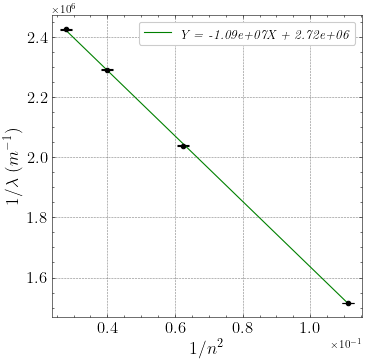

In [7]:
xdata, ydata, error_y = df2[drop_down_x.value], df2[drop_down_y.value], df2[drop_down_error_y.value]
parameters, covariance = opt.curve_fit(linear, xdata, ydata, sigma = error_y)
slope = parameters[0]
b = parameters[1]

#Calculate the error on the fits from the covariacne matrix
perr = np.sqrt(np.diag(covariance))
slope_error = perr[0]
b_error = perr[1]
    
# PLOTTING THE DATA ---------------------------------------
title = r'$\textbf{Deformation (m) vs Mass (Kg)}$'
LinearPlot(xdata,ydata,error_y,slope,b,title,linear,drop_down_x.value,drop_down_y.value,'green')

In [8]:
slope = abs(slope)
slope_theor = 1.096776*10**7
units = 'm-1'
print('Experimental Rydberg constant: (', slope, ' ± ', slope_error, ")", units)
print('Theoretical Rydberg constant: ' + "{:.4e}".format(slope_theor) + ' ' + units)

# DETERMING THE %ERROR
error = abs((slope-slope_theor)/slope_theor)*100
print("Percentage error: ", error, "%")
exp_precision = 100*slope_error/slope
print('Experimental precision:', exp_precision, '%')
print('Sigmas:', error/exp_precision)

Experimental Rydberg constant: ( 10887237.727981407  ±  54956.03100276205 ) m-1
Theoretical Rydberg constant: 1.0968e+07 m-1
Percentage error:  0.7341724474149034 %
Experimental precision: 0.5047747865514037 %
Sigmas: 1.454455466032155


## ALL ORDERS DATA

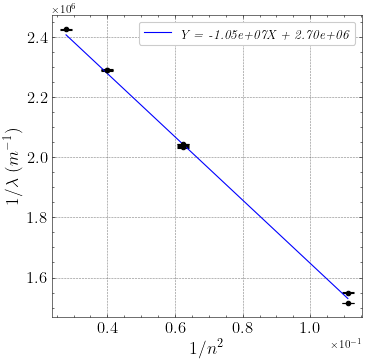

In [9]:
xdata, ydata, error_y = df[drop_down_x.value], df[drop_down_y.value], df[drop_down_error_y.value]
parameters, covariance = opt.curve_fit(linear, xdata, ydata, sigma = error_y)
slope = parameters[0]
b = parameters[1]

#Calculate the error on the fits from the covariacne matrix
perr = np.sqrt(np.diag(covariance))
slope_error = perr[0]
b_error = perr[1]

# PLOTTING THE DATA ---------------------------------------
title = r'$\textbf{Deformation (m) vs Mass (Kg)}$'
LinearPlot(xdata,ydata,error_y,slope,b,title,linear,drop_down_x.value,drop_down_y.value,'blue')

In [10]:
slope = abs(slope)
slope_theor = 1.096776*10**7
units = 'm-1'
print('Experimental Rydberg constant: (', slope, ' ± ', slope_error, ")", units)
print('Theoretical Rydberg constant: ' + "{:.4e}".format(slope_theor) + ' ' + units)

# DETERMING THE %ERROR
error = abs((slope-slope_theor)/slope_theor)*100
print("Percentage error: ", error, "%")
exp_precision = 100*slope_error/slope
print('Experimental precision:', exp_precision, '%')
print('Sigmas:', error/exp_precision)

Experimental Rydberg constant: ( 10521065.698099991  ±  197874.78733799825 ) m-1
Theoretical Rydberg constant: 1.0968e+07 m-1
Percentage error:  4.072794279780089 %
Experimental precision: 1.8807485193608537 %
Sigmas: 2.1655177382057285


# WEIGHTED AVERAGES

In [33]:
# Generating arrays for saving the weighted averages found
lambdas_inv, errors = [], []

In [34]:
# RED LINE -----------------------------------------
df_test = df[(df['Line color'] == 'Red')]
df_test

,Order Maxima,Line color,Left (°),Right (°),Average Angle (°),Angle (Rad),Uncertainty (°),Uncertainty (Rad),m,Lambda (m),Energy level n,$1/\lambda \ (m^{-1})$,$1/n^2$,Error n,Avg angle error,Error lambda,Error 1/lambda
0,First,Red,156.566667,203.233333,23.333333,0.407243,0.016667,0.000291,1,6.601329e-07,3,1514846.381,0.111111,NaN,0.000206,3.147783e-10,722.340655
1,Second,Red,NaN,230.733333,50.733333,0.885464,0.016667,0.000291,2,6.451738e-07,3,1549969.936,0.111111,NaN,0.000291,3.068534e-10,737.186844


In [35]:
lambda1, lambda2 = df_test.at[0,'Lambda (m)'], df_test.at[1,'Lambda (m)'] 
err1, err2 = df_test.at[0,'Error lambda'], df_test.at[1,'Error lambda'] 
print('Lambda1 = ', lambda1, '±', err1, 'm')
print('Lambda2 = ', lambda2, '±', err2, 'm')

Lambda1 =  6.601329434e-07 ± 3.1477829065644604e-10 m
Lambda2 =  6.45173804e-07 ± 3.068533920318356e-10 m


In [36]:
# DEFINING A FUNCTION THAT RETURNS THE WEIGHTED AVERAGE WITH UNCERTAINTY
def weighted_avgs(values, deltas):
    weights = np.array(list(map(lambda x : 1/x**2, deltas)))
    best_val = np.dot(np.array(values), weights)/weights.sum()
    uncert = 1/np.sqrt(weights.sum())
    return [best_val, uncert]

In [37]:
wa = weighted_avgs([lambda1, lambda2], [err1, err2])
lambda_avg, uncert = wa[0], wa[1]
lambdas_inv.append(1/lambda_avg), errors.append(uncertainty_var([lambda_avg], [uncert], lambda_inverse))
print('Lambda_avg = ', lambda_avg, '±', uncert, 'm')

Lambda_avg =  6.524626974485137e-07 ± 2.197264144594314e-10 m


In [38]:
# BLUE-GREEN LINE -----------------------------------------
df_test = df[(df['Line color'] == 'Blue-Green')]
df_test

,Order Maxima,Line color,Left (°),Right (°),Average Angle (°),Angle (Rad),Uncertainty (°),Uncertainty (Rad),m,Lambda (m),Energy level n,$1/\lambda \ (m^{-1})$,$1/n^2$,Error n,Avg angle error,Error lambda,Error 1/lambda
2,First,Blue-Green,163.00,197.233333,17.116667,0.298742,0.016667,0.000291,1,4.905306e-07,4,2038608.931,0.0625,NaN,0.000206,3.276309e-10,1361.610439
3,Second,Blue-Green,143.50,215.416667,35.958333,0.627591,0.016667,0.000291,2,4.893306e-07,4,2043607.995,0.0625,NaN,0.000206,2.774897e-10,1158.889755
4,Third,Blue-Green,114.15,238.816667,62.333333,1.087922,0.016667,0.000291,3,4.920355e-07,4,2032373.657,0.0625,NaN,0.000206,1.591782e-10,657.492554


In [39]:
lambda1, lambda2, lambda3 = df_test.at[2,'Lambda (m)'], df_test.at[3,'Lambda (m)'], df_test.at[4,'Lambda (m)']
err1, err2, err3 = df_test.at[2,'Error lambda'], df_test.at[3,'Error lambda'], df_test.at[4,'Error lambda'] 
print('Lambda1 = ', lambda1, '±', err1, 'm')
print('Lambda2 = ', lambda2, '±', err2, 'm')
print('Lambda3 = ', lambda3, '±', err3, 'm')

Lambda1 =  4.905305695e-07 ± 3.276308839979242e-10 m
Lambda2 =  4.89330636e-07 ± 2.774896553870811e-10 m
Lambda3 =  4.920355056e-07 ± 1.5917823286762677e-10 m


In [40]:
wa = weighted_avgs([lambda1, lambda2, lambda3], [err1, err2, err3])
lambda_avg, uncert = wa[0], wa[1]
lambdas_inv.append(1/lambda_avg), errors.append(uncertainty_var([lambda_avg], [uncert], lambda_inverse))
print('Lambda_avg = ', lambda_avg, '±', uncert, 'm')

Lambda_avg =  4.912398425486479e-07 ± 1.272365432939907e-10 m


In [41]:
# BLUE-VIOLET LINE -----------------------------------------
df_test = df[(df['Line color'] == 'Blue-Violet')]
df_test

,Order Maxima,Line color,Left (°),Right (°),Average Angle (°),Angle (Rad),Uncertainty (°),Uncertainty (Rad),m,Lambda (m),Energy level n,$1/\lambda \ (m^{-1})$,$1/n^2$,Error n,Avg angle error,Error lambda,Error 1/lambda
5,First,Blue-Violet,164.883333,195.250000,15.183333,0.264999,0.016667,0.000291,1,4.365141e-07,5,2290876.782,0.04,NaN,0.000206,3.308483e-10,1736.331392
6,Second,Blue-Violet,148.000000,211.233333,31.616667,0.551815,0.016667,0.000291,2,4.368614e-07,5,2289055.692,0.04,NaN,0.000206,2.919325e-10,1529.661776


In [42]:
lambda1, lambda2 = df_test.at[5,'Lambda (m)'], df_test.at[6,'Lambda (m)'] 
err1, err2 = df_test.at[5,'Error lambda'], df_test.at[6,'Error lambda'] 
print('Lambda1 = ', lambda1, '±', err1, 'm')
print('Lambda2 = ', lambda2, '±', err2, 'm')

Lambda1 =  4.365140927e-07 ± 3.308482990890899e-10 m
Lambda2 =  4.368613676e-07 ± 2.9193253762862496e-10 m


In [43]:
wa = weighted_avgs([lambda1, lambda2], [err1, err2])
lambda_avg, uncert = wa[0], wa[1]
lambdas_inv.append(1/lambda_avg), errors.append(uncertainty_var([lambda_avg], [uncert], lambda_inverse))
print('Lambda_avg = ', lambda_avg, '±', uncert, 'm')

Lambda_avg =  4.3670934594570197e-07 ± 2.1889958383039714e-10 m


In [44]:
# VIOLET LINE --- only one value
lambda_avg, uncert = df.at[7,'Lambda (m)'], df.at[7,'Error lambda']
lambdas_inv.append(1/lambda_avg), errors.append(uncertainty_var([lambda_avg], [uncert], lambda_inverse))
print('Lambda_avg = ', lambda_avg, '±', uncert, 'm')

Lambda_avg =  4.123696701e-07 ± 3.3215618787888516e-10 m


In [45]:
lambdas_inv, errors

([1532654.6696240986,
  2035665.5006072095,
  2289852.5284236404,
  2425008.608798749],
 [516.1440717923688, 527.2598770336481, 1147.783751588082, 1953.3011180816684])

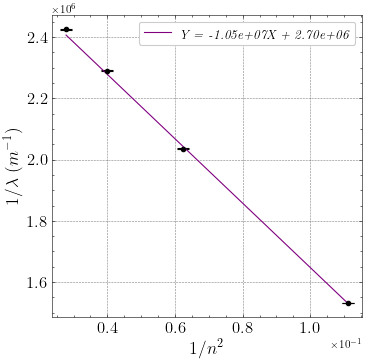

In [46]:
# GENERATING PLOT USING WEIGHTED AVERAGES DATA
xdata, ydata, error_y = df2[drop_down_x.value], lambdas_inv, errors
parameters, covariance = opt.curve_fit(linear, xdata, ydata, sigma = error_y)
slope = parameters[0]
b = parameters[1]

#Calculate the error on the fits from the covariacne matrix
perr = np.sqrt(np.diag(covariance))
slope_error = perr[0]
b_error = perr[1]

# PLOTTING THE DATA ---------------------------------------
title = r'$\textbf{Deformation (m) vs Mass (Kg)}$'
LinearPlot(xdata,ydata,error_y,slope,b,title,linear,drop_down_x.value,drop_down_y.value,'purple')

In [49]:
slope = abs(slope)
slope_theor = 1.096776*10**7
units = 'm-1'
print('Experimental Rydberg constant: (', slope, ' ± ', slope_error, ")", units)
print('Theoretical Rydberg constant: ' + "{:.4e}".format(slope_theor) + ' ' + units)

# DETERMING THE %ERROR
error = abs((slope-slope_theor)/slope_theor)*100
print("Percentage error: ", error, "%")
exp_precision = 100*slope_error/slope
print('Experimental precision:', exp_precision, '%')
print('Sigmas:', error/exp_precision)

Experimental Rydberg constant: ( 10511216.739289418  ±  158871.9894285409 ) m-1
Theoretical Rydberg constant: 1.0968e+07 m-1
Percentage error:  4.162593462207252 %
Experimental precision: 1.5114519409984215 %
Sigmas: 2.754036267575642
